# **U-NET**
U-net is a segmentation algorithm for dividing regions in an image.

The algorithm has a symmetric structure, starting from the top left, moving through the bottom and outputting at the top right. Specifically, it processes the image through the following steps:

Convolution and pooling :
An image is input and a 3x3 convolution is performed. This process extracts important features from the image. Next, we use 2x2 max pooling to reduce the data size and make the calculations more efficient.

Scaling by deconvolution :
In order to return the data reduced by pooling to its original size, 2x2 deconvolution (upsampling) is performed. This makes it possible to restore fine features. In practice, this deconvolution allows for detailed region segmentation.

Combining (copying) features :
During the deconvolution process, the pre-convolution information from the same layer is used to complement the features, which allows us to recover some of the information lost in the previous stage. In practice, this has been shown to improve accuracy.

Essentially, U-net is an extension of the usual CNN (Convolutional Neural Network) approach, and for a concrete example, this algorithm is extremely useful in the medical field for detecting internal organs and organs.

In [1]:
import glob
import cv2
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 9)

2025-05-07 07:13:57.601604: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746602037.982939      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746602038.093683      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import zipfile
import os

# Path to the ZIP file
zip_path = '/kaggle/input/tgs-salt-identification-challenge/competition_data.zip'

# Destination folder (writable)
extract_path = '/kaggle/working/competition_data'

# Unzip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Unzipped to:", extract_path)

Unzipped to: /kaggle/working/competition_data


In [3]:
import os

for root, dirs, files in os.walk(extract_path):
    print(f" {root}")
    for name in files[:5]:  # limit to first 5 files for brevity
        print(f"   {name}")

 /kaggle/working/competition_data
 /kaggle/working/competition_data/__MACOSX
   ._competition_data
 /kaggle/working/competition_data/__MACOSX/competition_data
   ._train.csv
   ._.DS_Store
   ._test
   ._sample_submission.csv
   ._train
 /kaggle/working/competition_data/__MACOSX/competition_data/train
   ._images
   ._masks
 /kaggle/working/competition_data/__MACOSX/competition_data/train/masks
   ._a05da102a2.png
   ._d2ea97ca4e.png
   ._2c3c64402e.png
   ._86365721e2.png
   ._ab72556c51.png
 /kaggle/working/competition_data/__MACOSX/competition_data/train/images
   ._a05da102a2.png
   ._d2ea97ca4e.png
   ._2c3c64402e.png
   ._86365721e2.png
   ._ab72556c51.png
 /kaggle/working/competition_data/__MACOSX/competition_data/test
   ._images
 /kaggle/working/competition_data/__MACOSX/competition_data/test/images
   ._5a7566a915.png
   ._28abb87539.png
   ._eef671c610.png
   ._2cf2b06f33.png
   ._610f0279fa.png
 /kaggle/working/competition_data/competition_data
   sample_submission.csv
   .

In [4]:
# Data Loading
# image files
image_path_list = sorted(glob.glob("/kaggle/working/competition_data/competition_data/train/images/*.png"))

X_train = []
y_train = []

for image_path in image_path_list[:100]:  # just using first 100 for now
    # Read and normalize image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (256, 256)) / 255.0
    X_train.append(image)

    # Create corresponding mask path
    mask_path = image_path.replace("images", "masks")
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (256, 256)) / 255.0
    y_train.append(mask)

X_train = np.expand_dims(np.array(X_train), axis=-1)
y_train = np.expand_dims(np.array(y_train), axis=-1)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


X_train shape: (100, 256, 256, 1)
y_train shape: (100, 256, 256, 1)


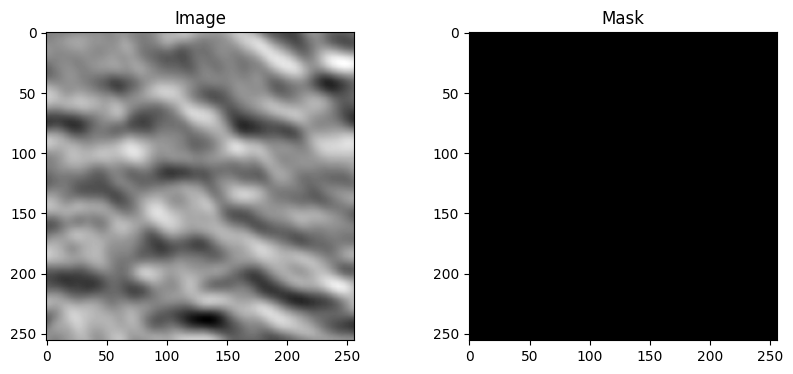

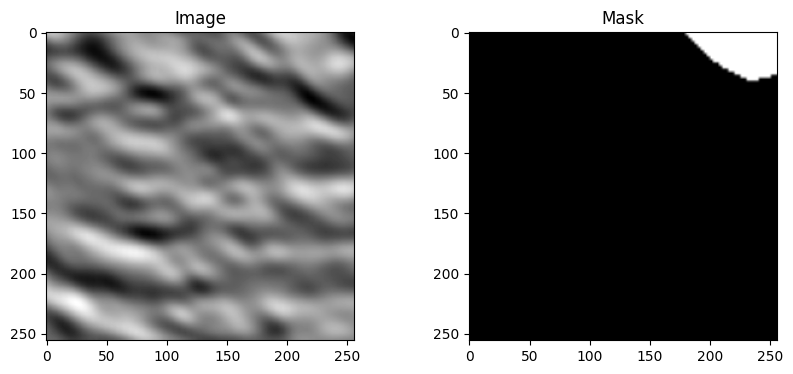

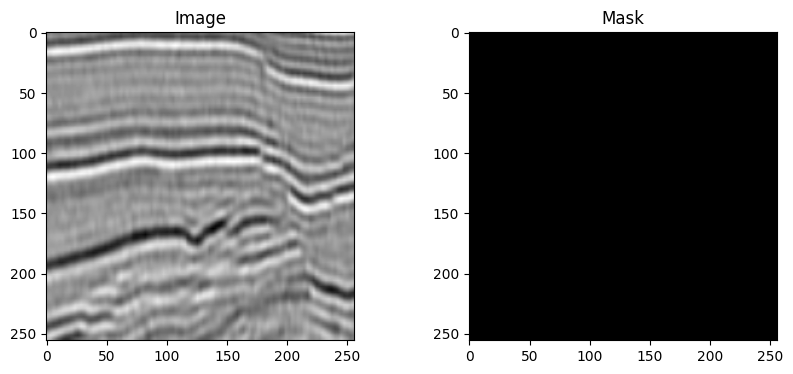

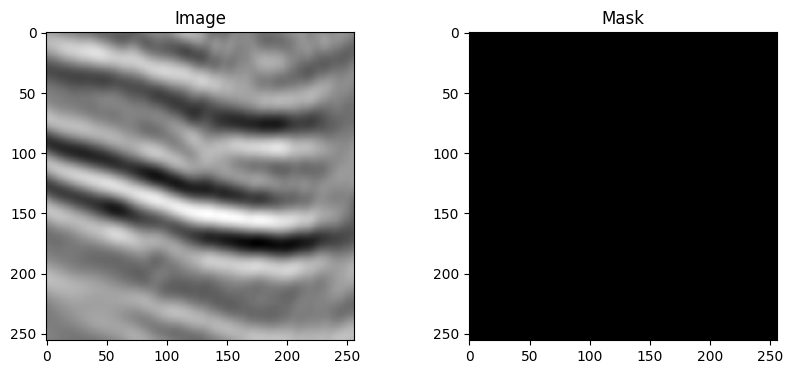

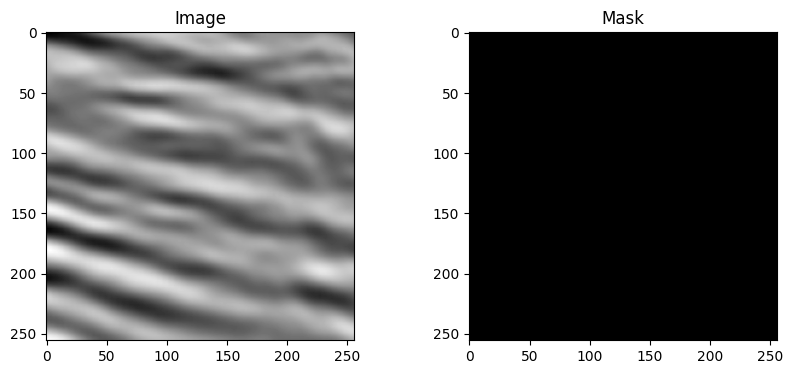

In [5]:
import matplotlib.pyplot as plt

# Show the first 5 image-mask pairs
for i in range(5):
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.imshow(X_train[i].squeeze(), cmap='gray')
    plt.title("Image")
    
    plt.subplot(1, 2, 2)
    plt.imshow(y_train[i].squeeze(), cmap='gray')
    plt.title("Mask")
    
    plt.show()

# Problem 1: Learning and Estimation
Used zhixuhao Keras implementation for training and estimation.

In [6]:
# Model Definition
import tensorflow.keras.backend as K
import tensorflow as tf
from keras.utils import register_keras_serializable

@register_keras_serializable()
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def unet(pretrained_weights=None, input_size=(256, 256, 1)):
    inputs = Input(input_size)
    
    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Bottleneck
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Decoder
    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)

    conv10 = Conv2D(1, 1, activation='sigmoid', name="output")(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy', dice_coef])

    if pretrained_weights:
        model.load_weights(pretrained_weights)

    return model

# Create the model
model = unet()

I0000 00:00:1746602066.615228      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746602066.615885      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Model checkpoint callback (optional, to save best model based on validation loss)
model_checkpoint = ModelCheckpoint('unet_best_model.keras', monitor='loss', verbose=1, save_best_only=True)

# Fit the model using the augmented training data
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=20,
    callbacks=[model_checkpoint],
    verbose=1
)

# Save the trained model after training
model.save('unet_model.keras')

# You can later load the model using:
model = tf.keras.models.load_model('unet_model.keras')


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1746602079.165487      65 service.cc:148] XLA service 0x7dee3c0043f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746602079.167404      65 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1746602079.167427      65 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1746602080.260210      65 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-07 07:14:48.407216: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng12{k11=0} for conv (f32[32,128,128,1

3/4 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - accuracy: 0.8157 - dice_coef: 0.1119 - loss: 1.5791

E0000 00:00:1746602225.727896      64 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746602226.030720      64 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746602232.303432      64 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746602232.535331      64 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.8075 - dice_coef: 0.1157 - loss: 1.6405
Epoch 1: loss improved from inf to 1.82456, saving model to unet_best_model.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 182s 15s/step - accuracy: 0.8026 - dice_coef: 0.1180 - loss: 1.6773
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7049 - dice_coef: 0.3124 - loss: 0.6526
Epoch 2: loss improved from 1.82456 to 0.59032, saving model to unet_best_model.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.7202 - dice_coef: 0.3073 - loss: 0.6402
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7958 - dice_coef: 0.2304 - loss: 0.5302
Epoch 3: loss improved from 0.59032 to 0.53470, saving model to unet_best_model.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.7931 - dice_coef: 0.2297 - loss: 0.5311
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7413 - dice_coef: 0.2751 - loss: 0.5825
Epoch 4: loss did not improve from 0.53470
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step 

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


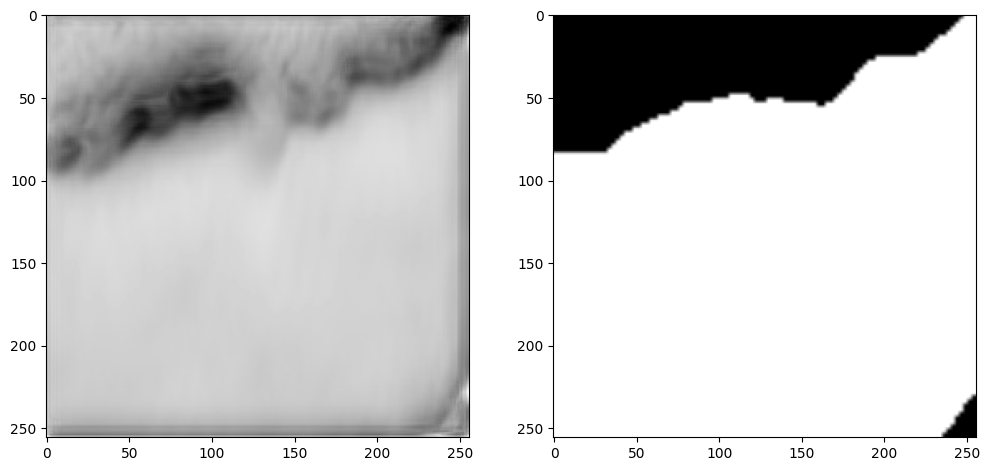

In [8]:
# Estimation
y_pred = model.predict(np.array([X_train[30, :, :, :]]))
fig, ax = plt.subplots(1, 2)
ax[0].imshow(y_pred[0, :, :, 0], cmap='gray')
ax[1].imshow(y_train[30], cmap='gray')

# Question 2: Code reading
Read the paper [1](https://arxiv.org/pdf/1505.04597.pdf) and do a code read of the above implementation.

# **HIGHLIGHTS FROM U-NET PAPER**
It proposes a U-Net architecture for semantic segmentation, which was originally designed for biomedical image segmentation tasks. The architecture includes:
1. Contracting Path (Encoder) - follows a typical convolutional network structure with downsampling layers (max-pooling), which capture the context of the input image. Each downsampling block contains two 3x3 convolutions followed by a max-pooling operation.

2. Bottleneck - consists of a deeper level of convolutions, where the image has been downsampled the most. Here, two 3x3 convolutions are applied, followed by dropout for regularization.

3. Expansive Path (Decoder) - aims to rebuild the spatial dimensions of the input image. This is done using UpSampling layers followed by convolutions. Skip connections are used to concatenate corresponding feature maps from the encoder to the decoder at each level. These help the model retain important features lost during downsampling.

4. Final Convolution - A 1x1 convolution layer is used at the final step to map the output to the required number of channels (for binary or multi-class segmentation).

5. Loss Function - The network uses binary cross-entropy as the loss function and Dice coefficient as the evaluation metric.

# **ABOVE IMPLEMENTATION BREAKDOWN**
1. Data Preprocessing and Augmentation

Data Augmentation: The paper does not specifically mention data augmentation but suggests applying transformations during training. The implementation introduces rotation, shifting, and zooming, which are standard data augmentation techniques that help improve generalization.

2. Model Architecture

Encoder (Contracting Path): This closely matches the downsampling path in the paper. Each block has two 3x3 convolutions followed by a MaxPooling operation, which reduces the spatial dimensions of the feature maps.

3. Bottleneck

The bottleneck has 1024 filters, and dropout (0.5) is applied to reduce overfitting. This matches the architecture described in the paper.

4. Decoder (Expansive Path)

UpSampling followed by concatenation with the corresponding layer from the encoder (drop4) and then convolution to refine the feature maps is the core idea of the expansive path. This matches the skip connections from the encoder to the decoder described in the paper.

5. Final Layer

The final 1x1 convolution maps the output to a single channel, with a sigmoid activation, which is typical for binary segmentation tasks.

6. Loss Function and Evaluation Metric

The binary cross-entropy loss function and Dice coefficient metric align with the paper’s approach, though the paper also mentions using softmax cross-entropy for multi-class segmentation.

Moreover:
Activation Functions: The paper mentions using ReLU for hidden layers and sigmoid for the output layer, which we’ve implemented correctly.

Dropout: The paper uses dropout layers at the bottleneck and decoder path, which helps to prevent overfitting. Our code also applies dropout at the same locations.

Final Convolution: The 1x1 convolution layer at the end is crucial for mapping the output to the desired number of channels, which we've implemented for binary segmentation.